# Notebook \#3 - Laplace Neural Operator

In this jupyter notebook, we are going to cover how Laplace Neural Operator can be used to solve a control problem that has differential equation as one of the constraint. The structure of the notebooks is as follows:
- Preinstall and import all needed libraries
- Generate a training dataset 
- Train operator
- Solve optimization problem
- Compare with analytical solution

In [2]:
#Make sure that you have installed all dependencies
#pip install -r requirements.txt
from torch.utils.data import DataLoader
import numpy as np

# utils folder contains all the functions to load the data, train the model and plot the results
# models folder contains the model architectures
from utils.data import MultiFunctionDatasetODE, custom_collate_ODE_fn_fno 
from models.lno import *
from utils.scripts import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate Dataset

Suppose we have a parametric differential equation. This can be any arbitrary ode/pde, but for the sake of simplicity, let it be:
$$\frac{dx}{dt} - x(t) + u(t) = 0$$
where $u(t)$ is some arbitrary function or "parameter". And $x(t)$ is such function that ode is solved correctly.

We would like to train a model that can learn a mapping $u(t)\rightarrow x(t)$

At first we need to generate a dataset. This can be done using `MultiFunctionDatasetODE` function. It would generate 1000000 functions of different function families (`'grf', 'linear', 'sine', 'polynomial', 'constant'`). 

The time range would be $[0,1]$. For the Laplace Neural Operator, time should be discretized. In our case we set `m=200`, implying "200 sensors" or measurments. 

We split this into batches of size `1024`

In [3]:
n_functions = 1000000
end_time = 1.0
batch_size = 1024
m = 200

dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=['grf', 'linear', 'sine', 'polynomial','constant'],
    end_time = end_time,
    num_domain = 200,
    num_initial = 20,
    grf_lb = 0.02,
    grf_ub = 0.5
)

dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate_ODE_fn_fno, shuffle=True)

# Laplace Neural Operator

You can find source code of the FNO in the `models/fno.py` file.

## Theory

## Lagrangian Neural Operator (LNO): Key Ideas

- **Follow the flow**  
  Track the solution along characteristic trajectories $\xi(t)$ instead of fixed-grid points.

- **Rational dynamics**  
  Learn a small set of complex poles $p_k$ and residues $r_k$ so that
  $$
    x_{\rm trans}(t)
    = \mathcal{F}^{-1}\!\Bigl[\frac{r_k}{i\omega - p_k}\,\hat{x}(\omega)\Bigr],
  $$
  $$
    x_{\rm ss}(t)
    = \sum_k\Bigl(-\frac{r_k}{i\,p_k}\Bigr)\,e^{p_k t}.
  $$

- **Local refinement**  
  A lightweight $1\times1$ convolution (or MLP) corrects fine-scale and nonlinear features.

- **Why it works**  
  Combines interpretable global filters (few exponentials) with flexible local corrections, yielding compact, accurate operator approximations.  


## Train model

The workflow is simple. To create a model, you need to call `LNO1d()`. It has only input parameters `modes` and `width`.

In [19]:
modes = 16
width = 8
model = LNO1d(width, modes, hidden_layer=128).cuda()

Then you need to define `optimizer` and `scheduler` with any preferable settings

In [20]:
step_size = 100
gamma = 0.9
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


To train LNO, you need to use your custom train function that depends on your problem. In our case, we have `train_lno()` from `utils.scripts.py`

Notice that `train_lno()` uses function `compute_loss()`, which is defined in the same file. Basically, this functions tells FNO that we are trying to learn:
$$\frac{dx}{dt} + x(t) - u(t) = 0$$
$$x(0) = 1$$
$$t\in[0,1]$$

Thus, in this problem we have 2 "sources of loss": initial and physics loss. You can define variable `w` to set different weights to either of losses. 

After every `10 epoch`, model is saved. Make sure to define a folder where you want to store models. By default, it is `trained_models/lno`

In [ ]:
epochs = 10
trained_model = train_lno(model, compute_loss_ode, dataloader, optimizer, scheduler, epochs, logging=False)

Epoch [1/10], Loss: 0.901283, Time: 45.84896 s
Epoch [2/10], Loss: 0.178941, Time: 45.538123 s
Epoch [3/10], Loss: 0.408194, Time: 45.587836 s
Epoch [4/10], Loss: 0.318540, Time: 45.646628 s
Epoch [5/10], Loss: 0.141051, Time: 45.550506 s
Epoch [6/10], Loss: 0.095547, Time: 45.472953 s
Epoch [7/10], Loss: 0.080240, Time: 45.44222 s
Epoch [8/10], Loss: 0.252535, Time: 45.299252 s
Epoch [9/10], Loss: 0.072714, Time: 45.331971 s
Epoch [10/10], Loss: 0.035377, Time: 45.398242 s


LNO is taking much longer time than FNO to converge to something substantial

## Load pre-trained model

Or you can just load pre-trained model as usually

In [12]:
modes = 16
width = 8

trained_model = LNO1d(width, modes)
trained_model.to(device)
trained_model.load_state_dict(torch.load('trained_models/lno/width-[8]-modes[16]/epochs_[50]_model_time_[20250423-174005]_loss_[0.0027].pth'))
trained_model.eval()  #

LNO1d(
  (fc0): Linear(in_features=2, out_features=8, bias=True)
  (conv0): PR()
  (w0): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

# Solve Control Problem

Once we succesefully trained Fourier Neural Operator. We can solve next control problem:
$$\text{min}_u \ \int_{0}^{1} (x^2 + u^2)dt$$
$$\text{s.t.} \ \frac{dx}{dt} = x - u$$
$$ x(0) = 1$$

***Note:*** everything related to implementation of objective function was explained in a notebook related to Deep-O-Net in `playground.ipynb`

Idea is simple, we have a model that maps $u$ to $x$. We can start from some random function $u$, find $x$ that solves ode and initial condition using NN. Calculate objective function:
$$\text{min}_u \ \int_{0}^{1} (x^2 + u^2)dt$$
Update $u$ and repeat process again. 

The whole process relies on the fact that LNO indeed can provide solution $x$.

`optimize_neural_operator()` solves this problem given pretrained FNO model. Notice that it has as input parameter `objective_function()` 

In [ ]:
m = 200 
end_time = 1
epochs = 1500
learning_rate = 0.001

u_opt, x_opt, t = optimize_neural_operator(trained_model, objective_function_ode, m, end_time, epochs, learning_rate)

Epoch [100/1500], Loss: 0.4404, time: 02:00:27.751717
Epoch [200/1500], Loss: 0.4134, time: 02:00:28.041957
Epoch [300/1500], Loss: 0.3972, time: 02:00:28.331528
Epoch [400/1500], Loss: 0.3873, time: 02:00:28.620401
Epoch [500/1500], Loss: 0.3813, time: 02:00:28.908535
Epoch [600/1500], Loss: 0.3775, time: 02:00:29.197548
Epoch [700/1500], Loss: 0.3753, time: 02:00:29.487938
Epoch [800/1500], Loss: 0.3739, time: 02:00:29.776969
Epoch [900/1500], Loss: 0.3731, time: 02:00:30.065850
Epoch [1000/1500], Loss: 0.3727, time: 02:00:30.354102
Epoch [1100/1500], Loss: 0.3724, time: 02:00:30.644869
Epoch [1200/1500], Loss: 0.3723, time: 02:00:30.934101
Epoch [1300/1500], Loss: 0.3722, time: 02:00:31.223467
Epoch [1400/1500], Loss: 0.3722, time: 02:00:31.516071
Epoch [1500/1500], Loss: 0.3721, time: 02:00:31.807217


## Comparison with analytical solution

From the paper "Convergence of the forward-backward sweep method in optimal control" by Michael McAsey et al, we know that analytical solution for this problem is:

$$x(t) = \frac{\sqrt{2}\cosh(\sqrt{2}(t-1)) - \sinh(\sqrt{2}(t-1))}{\sqrt{2}\cosh(\sqrt{2})+\sinh{\sqrt{2}}}$$
$$u(t) = \frac{\sinh(\sqrt{2}(t-1))}{\sqrt{2}\cosh(\sqrt{2})+\sinh{\sqrt{2}}}$$

We can use these functions to confirm that we indeed found an optimal solution.

In [31]:
def analytical_x(t):
    numerator = np.sqrt(2) * np.cosh(np.sqrt(2) * (t - 1)) - np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

def analytical_u(t):
    numerator = np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

t_plot = np.linspace(0, end_time, m)

analytical_x_vals = analytical_x(t_plot)
analytical_u_vals = analytical_u(t_plot)

x_found = x_opt.cpu().detach().numpy().flatten()
u_found = u_opt.cpu().detach().numpy().flatten()
u_tensor = torch.from_numpy(analytical_u_vals).float().unsqueeze(0).to(device)


Solution found by LNO is not perfect, but follows the shape of the analytical solution. When try find $x$ for the true analytical $u$, it returns the same function as "optimal" $x$ found by LNO. But it is slightly off (smaller) than true analytical $x$.

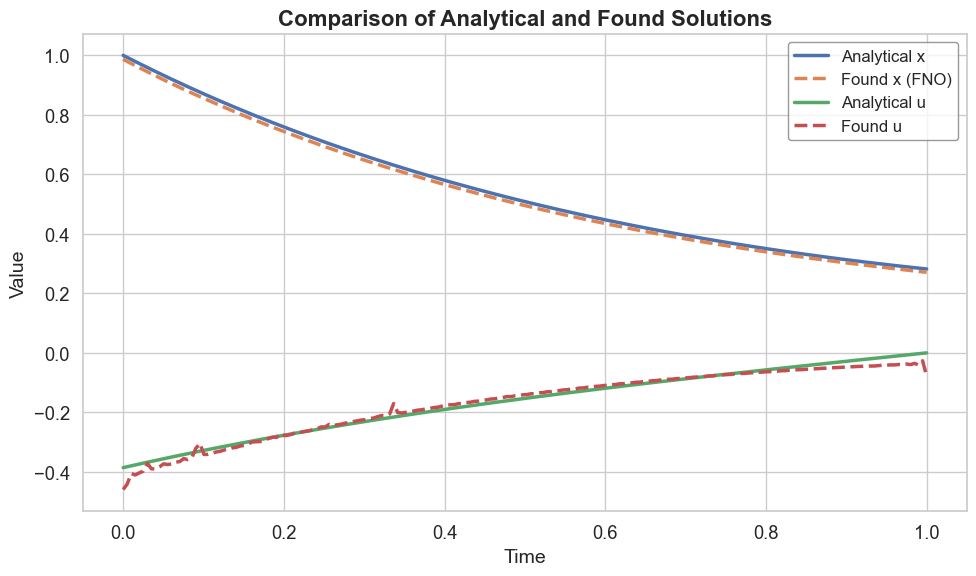

In [32]:
plot_analytical_and_found_solutions(t_plot, analytical_x_vals, x_found, analytical_u_vals, u_found)

In [ ]:
trained_model = LNO1d(modes=16, width=16, hidden_layer=64)
trained_model.to(device)
trained_model.load_state_dict(torch.load('trained_models/lno/epochs_[94]_model_time_[20250623-142207]_loss_[0.0028].pth'))
trained_model.eval()  #

RuntimeError: Error(s) in loading state_dict for LNO1d:
	size mismatch for conv0.weights_pole: copying a param with shape torch.Size([16, 16, 16]) from checkpoint, the shape in current model is torch.Size([16, 16, 32]).
	size mismatch for conv0.weights_residue: copying a param with shape torch.Size([16, 16, 16]) from checkpoint, the shape in current model is torch.Size([16, 16, 32]).

In [32]:
m = 200 
end_time = 1
epochs = 20000
learning_rate = 0.001

u_opt, x_opt, t_opt = optimize_neural_operator(trained_model, objective_function_nde, m, end_time, epochs, learning_rate,  w=[1, 0.1, 0, 0.001], model_name="lno")

Epoch [100/20000], Loss: 62.2398, time: 14:13:06.074748
Epoch [200/20000], Loss: 50.3059, time: 14:13:06.380810
Epoch [300/20000], Loss: 41.0948, time: 14:13:06.685190
Epoch [400/20000], Loss: 33.8906, time: 14:13:06.989608
Epoch [500/20000], Loss: 28.1865, time: 14:13:07.294650
Epoch [600/20000], Loss: 23.6214, time: 14:13:07.598838
Epoch [700/20000], Loss: 19.9365, time: 14:13:07.903149
Epoch [800/20000], Loss: 16.9438, time: 14:13:08.207050
Epoch [900/20000], Loss: 14.5117, time: 14:13:08.511009
Epoch [1000/20000], Loss: 12.5382, time: 14:13:08.815073
Epoch [1100/20000], Loss: 11.0764, time: 14:13:09.118864
Epoch [1200/20000], Loss: 9.8549, time: 14:13:09.423042
Epoch [1300/20000], Loss: 8.8292, time: 14:13:09.727607
Epoch [1400/20000], Loss: 7.9618, time: 14:13:10.068017
Epoch [1500/20000], Loss: 7.2196, time: 14:13:10.375870
Epoch [1600/20000], Loss: 6.5757, time: 14:13:10.679567
Epoch [1700/20000], Loss: 6.0088, time: 14:13:10.983460
Epoch [1800/20000], Loss: 5.5033, time: 14:13:

KeyboardInterrupt: 

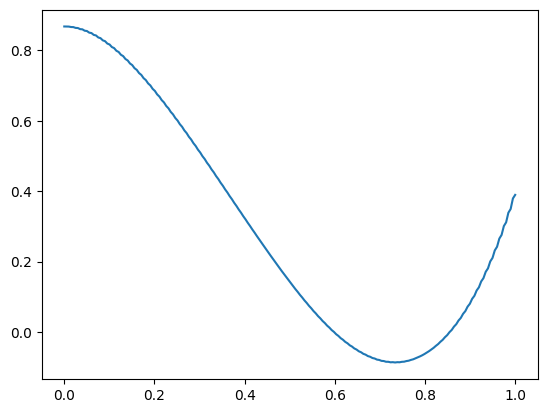

In [29]:
plt.plot(t_opt.cpu().detach().numpy().reshape(200), u_opt.cpu().detach().numpy().reshape(200), label='u found')

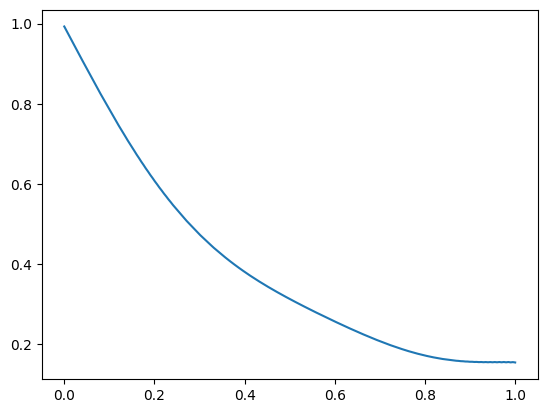

In [30]:
plt.plot(t_opt.cpu().detach().numpy().reshape(200), x_opt.cpu().detach().numpy().reshape(200), label='u found')

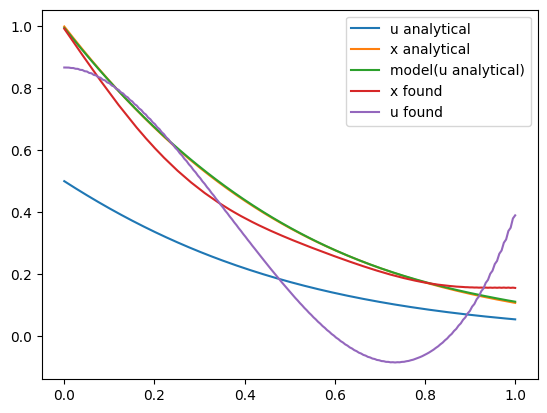

In [31]:
def analytical_x(t):
    return 4/(1+3*np.exp(5*t/2))

def analytical_u(t):
    return analytical_x(t)/2

t = np.linspace(0, 1, 200)
analytical_u_vals = analytical_u(t)
analytical_x_vals = analytical_x(t)

u_tensor = torch.from_numpy(analytical_u_vals).float().unsqueeze(0).to(device).reshape(1,200,1)  # shape [1, 200]
t_tensor = torch.from_numpy(t).float().to(device).reshape(1,200,1)  # shape [1, 200]

plt.plot(t, analytical_u_vals, label='u analytical')
plt.plot(t, analytical_x_vals, label='x analytical')
plt.plot(t, (trained_model(u_tensor, t_tensor).cpu().detach().numpy()).reshape(200), label='model(u analytical)')
plt.plot(t_opt.cpu().detach().numpy().reshape(200), x_opt.cpu().detach().numpy().reshape(200), label='x found')
plt.plot(t_opt.cpu().detach().numpy().reshape(200), u_opt.cpu().detach().numpy().reshape(200), label='u found')
plt.legend()